In [56]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
import pylustrator

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "poster", "plots")


def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}


def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

relevant_cols = ['group', 'obs_var', 'var_lower', 'var_upper', 'obs_kurt', 'kurt_lower',
       'kurt_upper', 'total_samples', 'initial_r', 'initial_eta', # 'initial_scale',
       'kstest_stat_initial', 'kstest_stat_cutoff_0.05',
       'best_r', 'best_eta', # 'best_scale', 
       'kstest_stat_best', # 'n_pval_0.05',
        'param_gaussian',
       'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
       'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
       'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 
       'dataset', 'subset', 'transform', 'orientation', 'channel', 'github_plot']

all_paths = find_master_dfs(os.path.join(ROOT_DIR, "results", "case-studies"))
all_master_dfs = []
github_plots_path = "https://github.com/yashdave003/hierarchical-bayesian-model-validation/blob/main/results/case-studies/"

# https://github.com/yashdave003/hierarchical-bayesian-model-validation/blob/main/results/case-studies
# /coco/indoor/wavelet/horizontal/blue/plots/compare_cdf_pdf_layer_2.jpg

for path in all_paths:
    if 'scaleTesting' in path:
        continue
    master_df = pd.read_csv(path)
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})

    parts = Path(path).parts[-7:]
    GROUP = 'layer'
    if parts[0] == 'case-studies':
        parts = parts[1:]
    if "MRI" in path:
        dataset, slice, transform, orientation, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = slice
        master_df['channel'] = np.nan
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, slice, transform, orientation, 'plots', f'compare_cdf_pdf_{GROUP}_{group}.jpg']) for group in master_df['group']]
    
    elif len(parts) > 6:
        dataset, subset, transform, orientation, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = subset
        master_df['channel'] = channel
        master_df['orientation'] = orientation
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, subset, transform, orientation, channel, 'plots', f'compare_cdf_pdf_{GROUP}_{group}.jpg']) for group in master_df['group']]
    else:
        dataset, size, transform, channel, _, _ = parts
        master_df['dataset'] = dataset
        master_df['transform'] = transform
        master_df['subset'] = size
        master_df['channel'] = channel
        master_df['orientation'] = np.nan
        master_df['github_plot'] = [github_plots_path+'/'.join([dataset, size, transform, channel, 'plots', f'compare_cdf_pdf_{GROUP}_{group}.jpg']) for group in master_df['group']]
    

    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
# main_df['prior_var'] = main_df.apply(lambda row : variance_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['prior_kurt'] = main_df.apply(lambda row : kurtosis_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['gaussian_kurt'] = np.zeros(main_df.shape[0])
# main_df['laplace_kurt'] = 3*np.ones(main_df.shape[0])
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 
main_df['total_samples'] = main_df['total_samples']//10 # TODO: look into why total_samples*10
main_df['kstest_stat_cutoff_0.10'] = stats.kstwo(n=main_df['total_samples']).isf(0.1)
kstest_stat_cutoff_2 = 0.2
kstest_stat_cutoff_2_name = 'kstest_stat_cutoff_0.20'
main_df[kstest_stat_cutoff_2_name] = stats.kstwo(n=main_df['total_samples']).isf(kstest_stat_cutoff_2)
main_df['beat_all_priors'] = (main_df['kstest_stat_best'] < np.minimum.reduce([main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])).astype(int)

frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
# main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()
main_df = main_df.set_index(['dataset', 'subset', 'transform', 'group']).reset_index() #[(main_df['dataset'] == 'pastis') | (main_df['dataset'] == 'agriVision') | (main_df['dataset'] == 'spaceNet')]
main_df

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),


,dataset,subset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,...,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma,orientation,channel,github_plot,best_beta,kstest_stat_cutoff_0.10,kstest_stat_cutoff_0.20,beat_all_priors
0,agriVision,full,fourier,2,1292.946700,749.107670,2108.430700,421.841550,123.974430,696.238040,...,0.019029,1.382990e-14,1.808228e-02,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,38.000000,0.018207,0.015955,1
1,agriVision,full,fourier,5,662.654400,382.089750,1248.617800,628.030000,108.212240,1663.239500,...,0.014947,3.910420e-23,7.143833e-03,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,43.333333,0.011300,0.009903,1
2,agriVision,full,fourier,8,256.633900,133.792040,650.845600,1363.730700,99.365600,3639.235800,...,0.012822,2.031100e-27,1.120706e-04,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,53.333333,0.008893,0.007794,1
3,agriVision,full,fourier,11,121.961570,57.215298,390.192930,2698.317600,93.680930,4889.278000,...,0.009905,1.306640e-42,1.278194e-05,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,55.555556,0.005497,0.004818,1
4,agriVision,full,fourier,14,48.468010,23.179575,151.679550,2654.295200,86.305040,4711.629400,...,0.009186,1.510880e-83,3.586150e-06,NaN,blue,https://github.com/yashdave003/hierarchical-ba...,56.666667,0.003633,0.003184,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,syntheticMRI3D,full,wavelet,4,241418.060000,225806.880000,257381.550000,4.450259,4.034465,4.879806,...,0.019904,3.458100e-08,2.871511e-01,ddd,NaN,https://github.com/yashdave003/hierarchical-ba...,1.400000,0.025709,0.022526,1
621,syntheticMRI3D,full,wavelet,5,33947.695000,31871.596000,36147.625000,3.966855,3.001096,5.099455,...,0.011334,1.530190e-33,8.425889e-01,ddd,NaN,https://github.com/yashdave003/hierarchical-ba...,101.000000,0.007099,0.006222,1
622,syntheticMRI3D,full,wavelet,6,6416.669400,5792.756300,7090.980500,13.477583,10.768813,16.435010,...,0.006007,1.010200e-90,4.771315e-54,ddd,NaN,https://github.com/yashdave003/hierarchical-ba...,56.000000,0.002280,0.001998,1
623,syntheticMRI3D,full,wavelet,7,397.892600,357.501070,450.380680,17.566162,9.929181,54.616486,...,0.015012,0.000000e+00,5.369889e-182,ddd,NaN,https://github.com/yashdave003/hierarchical-ba...,37.000000,0.000768,0.000674,1


In [57]:
main_df[['total_samples', 'dataset', 'subset', 'transform', 'orientation', 'channel', 'group', 'kstest_stat_best', 'kstest_stat_cutoff_0.05', 'beat_all_priors', 'github_plot']].to_csv('combined_categories.csv')

In [58]:
fontsize = 20
markersize = 10
labelsize = 20
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha\geq0.05$', r'$\alpha\geq0.10$', rf'$\alpha\geq{round_to_sigfigs(kstest_stat_cutoff_2, 2)}$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [
    Rectangle((0, 0), 1, 1, color='black', alpha=0.1),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.3),
    Rectangle((0, 0), 1, 1, color='black', alpha=0.5)
]

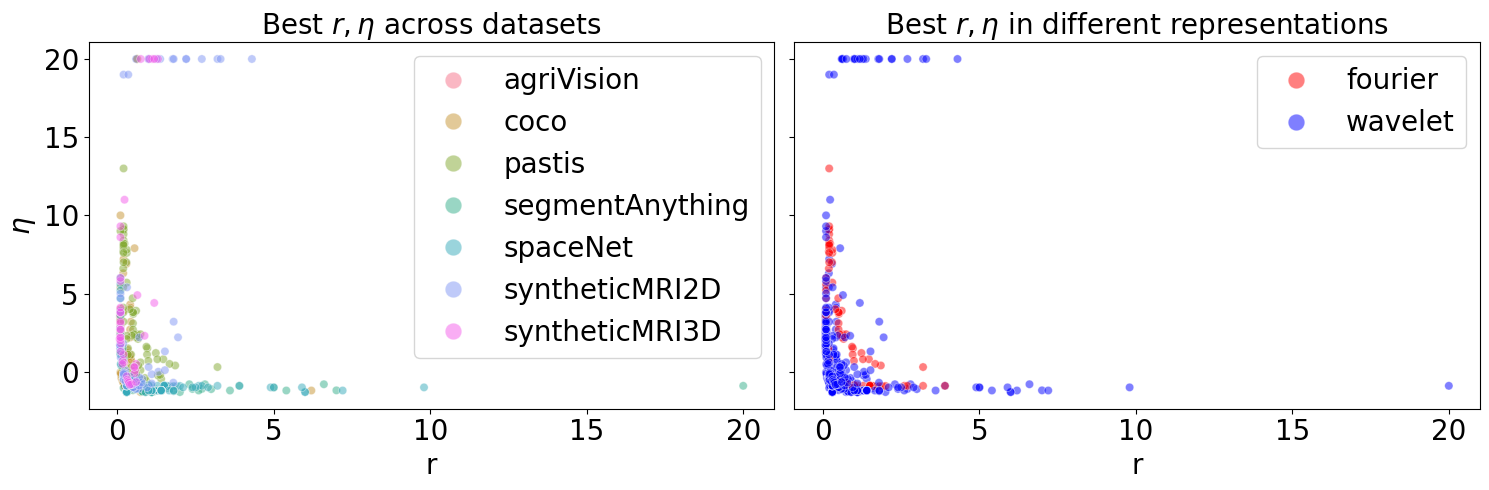

In [59]:
temp = main_df
log_scale = False
r_vals = np.linspace(1, temp['best_r'].max(), 1000)
beta_vals = 3 / (2 * r_vals)

r_vals_2 = np.linspace(0.01, 1, 1000)
beta_vals_2 = 3 / (2 * r_vals_2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='dataset', ax=ax1, alpha=0.5)

ax1.set_title(r'Best $r, \eta$ across datasets', fontsize=20)
ax1.set_ylabel(r'$\eta$', fontsize=20)
ax1.set_xlabel(f"{'Log ' if log_scale else ''}r", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
if log_scale:
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    

# Second plot
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', ax=ax2, alpha=0.5)
ax2.set_title(r'Best $r, \eta$ in different representations', fontsize=20)
ax2.set_ylabel('')
ax2.set_xlabel(f"{'Log ' if log_scale else ''}r", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
if log_scale:
    ax2.set_xscale('log')
    ax2.set_yscale('log')

ax1.legend(markerscale=2, fontsize=20)
ax2.legend(markerscale=2, fontsize=20)
plt.tight_layout()
plt.show()

In [60]:
r_vals = np.append(np.linspace(0, 1, 101), np.linspace(1, 20, 11))
eta_vals = np.append(np.linspace(-1.5, 1, 201), np.linspace(1, 20, 11))
R, ETA = np.meshgrid(r_vals, eta_vals)
BETA = (ETA + 1.5) / R

# plt.scatter(R, ETA)


C:\Users\yashd\AppData\Local\Temp\ipykernel_54788\4265121456.py:4: RuntimeWarning: divide by zero encountered in divide
  BETA = (ETA + 1.5) / R
C:\Users\yashd\AppData\Local\Temp\ipykernel_54788\4265121456.py:4: RuntimeWarning: invalid value encountered in divide
  BETA = (ETA + 1.5) / R


In [61]:
sns.lineplot(x=r_vals+r_vals_2, y=beta_vals+beta_vals_2)
sns.lineplot(x=r_vals+r_vals_2, y=beta_vals+beta_vals_2)
plt.xscale('log')
plt.yscale('log')

ValueError: operands could not be broadcast together with shapes (112,) (1000,) 

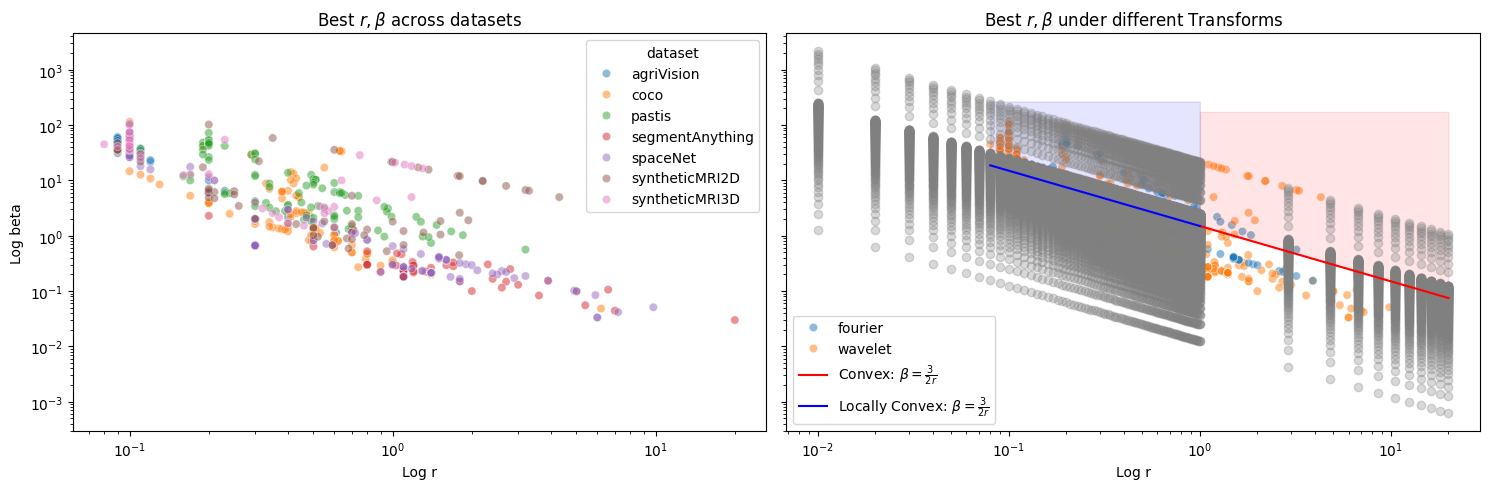

In [ ]:
temp = main_df
log_scale = True
r_vals = np.linspace(1, temp['best_r'].max(), 1000)
beta_vals = 3 / (2 * r_vals)

# Create r and beta values for the second line
r_vals_2 = np.linspace(temp['best_r'].min(), 1, 1000)
beta_vals_2 = 3 / (2 * r_vals_2)

# Create figure with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# First plot
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='dataset', ax=ax1, alpha=0.5)

ax1.set_title(r'Best $r, \beta$ across datasets')
if log_scale:
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel('Log beta')
    ax1.set_xlabel('Log r')

# Second plot
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='transform', ax=ax2, alpha=0.5)
sns.lineplot(x=r_vals, y=beta_vals, label=r'Convex: $\beta = \frac{3}{2r}$', color='red', ax=ax2)
sns.lineplot(x=r_vals_2, y=beta_vals_2, label=r'Locally Convex: $\beta = \frac{3}{2r}$', color='blue', ax=ax2)
# Shade the region above the line
ax2.fill_between(r_vals, beta_vals, y2=ax2.get_ylim()[1], color='red', alpha=0.1)
ax2.fill_between(r_vals_2, beta_vals_2, y2=ax2.get_ylim()[1], color='blue', alpha=0.1)
ax2.set_title(r'Best $r, \beta$ under different Transforms')
ax2.scatter(R, BETA, color='gray', alpha=0.3)
if log_scale:
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    # Remove y-label from second plot since it's shared
    ax2.set_ylabel('')
    ax2.set_xlabel('Log r')

plt.tight_layout()
plt.show()


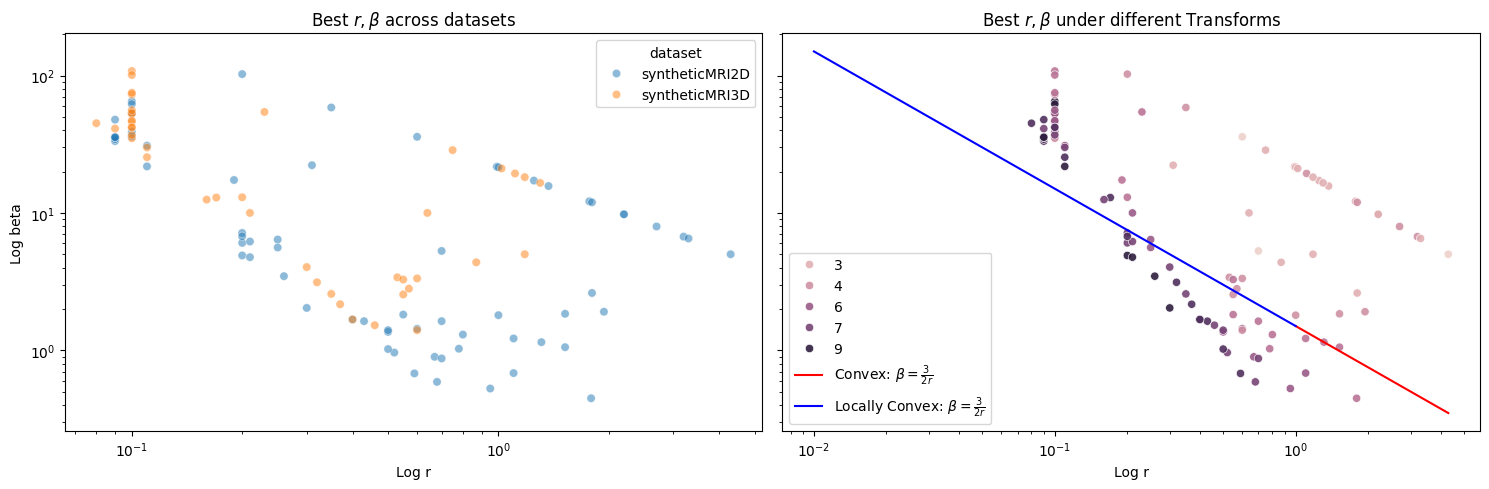

In [ ]:
temp = main_df[main_df['dataset'].isin(['syntheticMRI2D', 'syntheticMRI3D'])]
log_scale = True
r_vals = np.linspace(1, temp['best_r'].max(), 1000)
beta_vals = 3 / (2 * r_vals)

# Create r and beta values for the second line
r_vals_2 = np.linspace(0.01, 1, 1000)
beta_vals_2 = 3 / (2 * r_vals_2)

# Create figure with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# First plot
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='dataset', ax=ax1, alpha=0.5)

ax1.set_title(r'Best $r, \beta$ across datasets')
if log_scale:
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel('Log beta')
    ax1.set_xlabel('Log r')

# Second plot
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='group', ax=ax2, alpha=0.9)
sns.lineplot(x=r_vals, y=beta_vals, label=r'Convex: $\beta = \frac{3}{2r}$', color='red', ax=ax2)
sns.lineplot(x=r_vals_2, y=beta_vals_2, label=r'Locally Convex: $\beta = \frac{3}{2r}$', color='blue', ax=ax2)
# Shade the region above the line
# ax2.fill_between(r_vals, beta_vals, y2=ax2.get_ylim()[1], color='red', alpha=0.1)
# ax2.fill_between(r_vals_2, beta_vals_2, y2=ax2.get_ylim()[1], color='blue', alpha=0.1)
ax2.set_title(r'Best $r, \beta$ under different Transforms')
if log_scale:
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    # Remove y-label from second plot since it's shared
    ax2.set_ylabel('')
    ax2.set_xlabel('Log r')

plt.tight_layout()
plt.show()


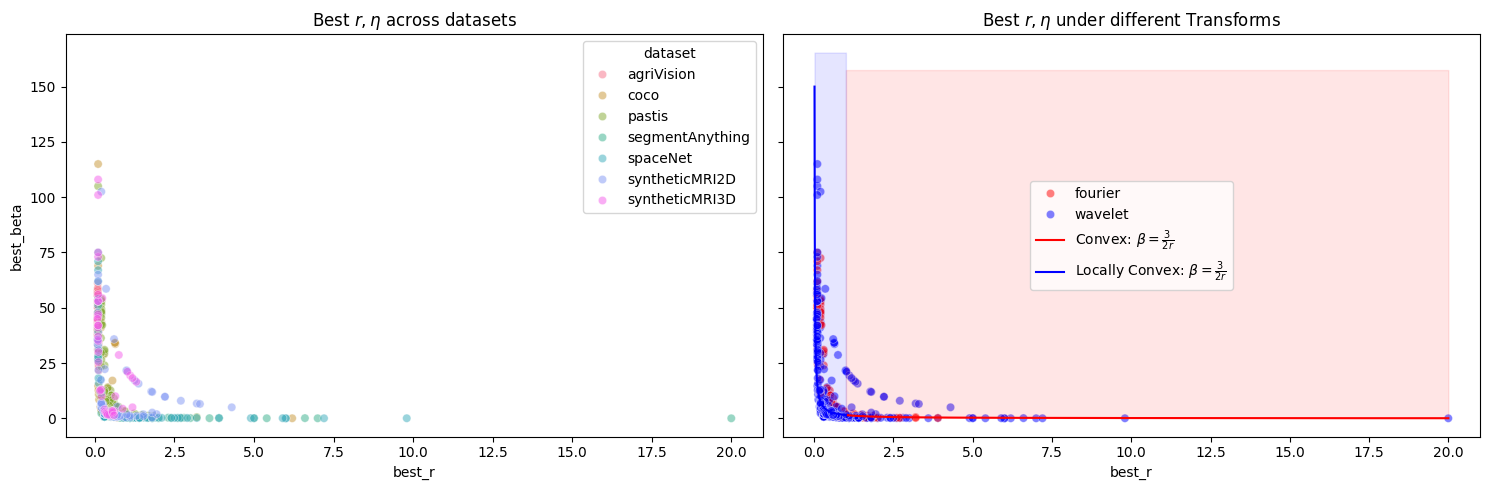

In [ ]:
temp = main_df
log_scale = False
r_vals = np.linspace(1, temp['best_r'].max(), 1000)
beta_vals = 3 / (2 * r_vals)

# Create r and beta values for the second line
r_vals_2 = np.linspace(0.01, 1, 1000)
beta_vals_2 = 3 / (2 * r_vals_2)

# Create figure with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# First plot
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='dataset', ax=ax1, alpha=0.5)

ax1.set_title(r'Best $r, \eta$ across datasets')
if log_scale:
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_ylabel('Log beta')
    ax1.set_xlabel('Log r')

# Second plot
sns.scatterplot(data=temp, x='best_r', y='best_beta', hue='transform', ax=ax2, alpha=0.5)
sns.lineplot(x=r_vals, y=beta_vals, label=r'Convex: $\beta = \frac{3}{2r}$', color='red', ax=ax2)
sns.lineplot(x=r_vals_2, y=beta_vals_2, label=r'Locally Convex: $\beta = \frac{3}{2r}$', color='blue', ax=ax2)
# Shade the region above the line
ax2.fill_between(r_vals, beta_vals, y2=ax2.get_ylim()[1], color='red', alpha=0.1)
ax2.fill_between(r_vals_2, beta_vals_2, y2=ax2.get_ylim()[1], color='blue', alpha=0.1)
ax2.set_title(r'Best $r, \eta$ under different Transforms')
if log_scale:
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    # Remove y-label from second plot since it's shared
    ax2.set_ylabel('')
    ax2.set_xlabel('Log r')

plt.tight_layout()
plt.show()


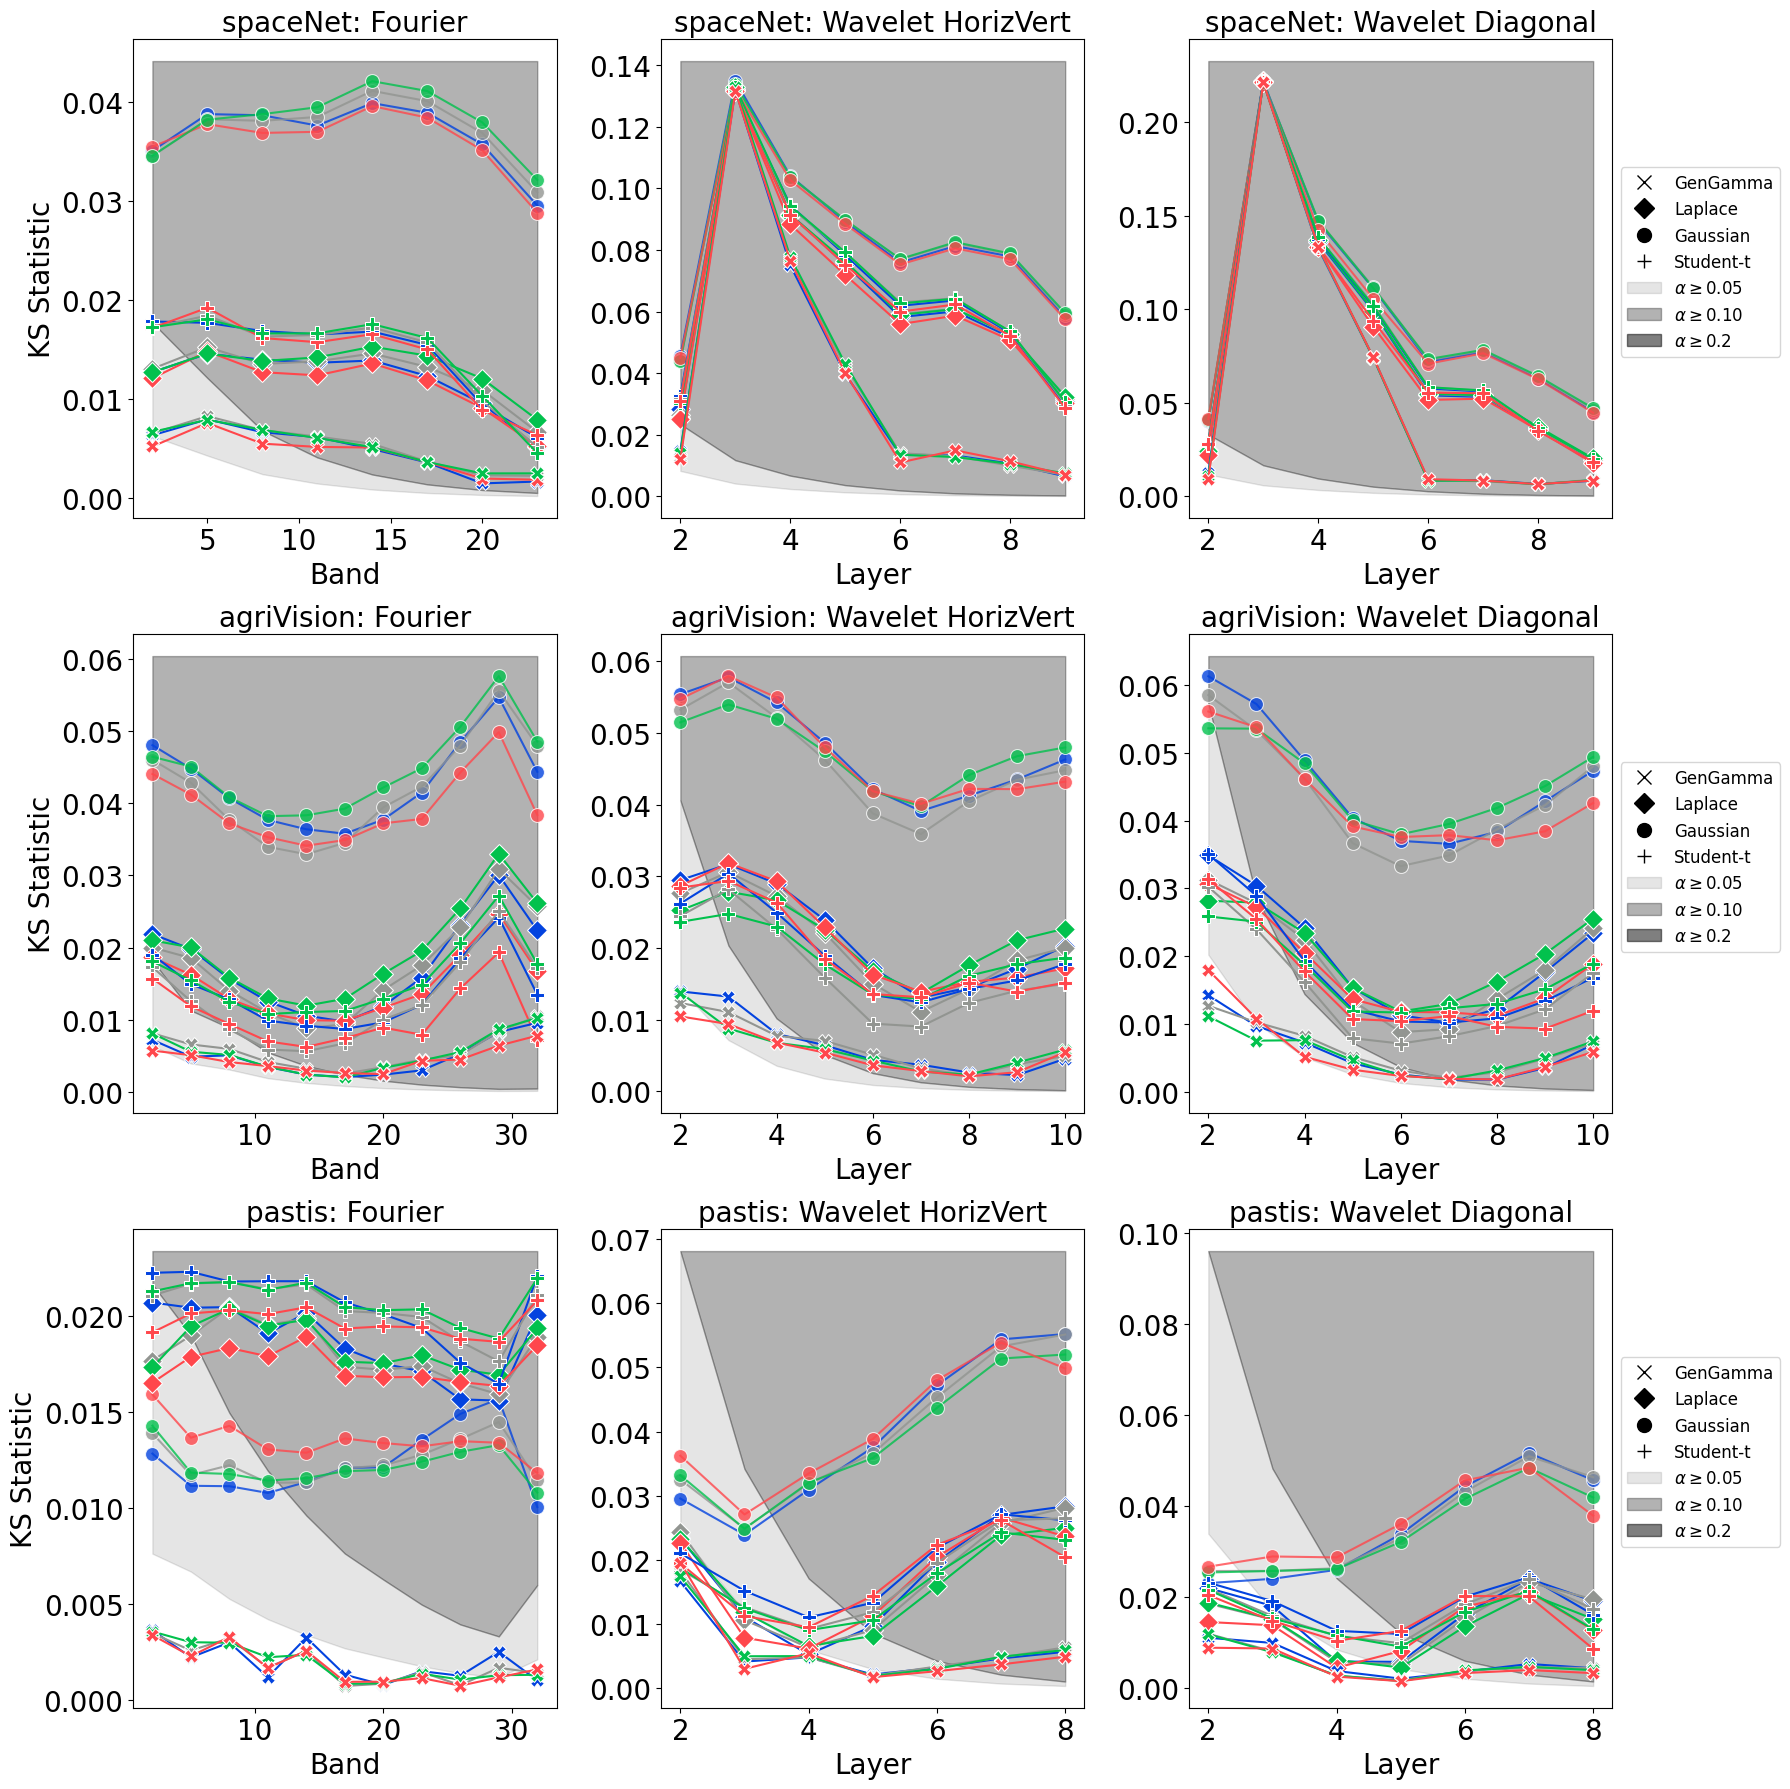

In [ ]:
hue = 'channel'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}
marker_size = 10  # Define marker size
toggle_markeredgecolor = True  # Set to True to enable markeredgecolor, False to disable

datasets_to_include = ['spaceNet', 'agriVision', 'pastis']  # List of datasets to include
num_datasets = len(datasets_to_include)

fig, axes = plt.subplots(num_datasets, 3, figsize=(18, 6 * num_datasets))

for i, dataset_name in enumerate(datasets_to_include):
    hue = 'channel'
    fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}

    transform = 'fourier'
    GROUP_NAME = 'Band'
    dataset_filter = (main_df['dataset'] == dataset_name)
    transform_filter = (main_df['transform'] == transform)
    temp = main_df[dataset_filter & transform_filter]
    temp = temp.sort_values('kstest_stat_cutoff_0.05')
    

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 0], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_0 = axes[i, 0].get_xlim()
    y_lim_0 = axes[i, 0].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 0].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 0].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_0[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)
    axes[i, 0].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 0].set_ylabel("KS Statistic", fontsize=fontsize)
    axes[i, 0].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 0].set_title(f"{dataset_name}: Fourier", fontsize=fontsize)
    axes[i, 0].tick_params(axis='both', which='major', labelsize=fontsize)

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'horizVert')
    temp = main_df[dataset_filter & transform_filter]

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 1], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_1 = axes[i, 1].get_xlim()
    y_lim_1 = axes[i, 1].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 1].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 1].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_1[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)
    axes[i, 1].legend(points, labels, fontsize=12).set_visible(False)
    axes[i, 1].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 1].set_ylabel("", fontsize=fontsize)
    axes[i, 1].set_title(f"{dataset_name}: Wavelet HorizVert", fontsize=fontsize)
    axes[i, 1].tick_params(axis='both', which='major', labelsize=fontsize)

    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    transform_filter = (main_df['transform'] == transform) & (main_df['orientation'] == 'diagonal')
    temp = main_df[dataset_filter & transform_filter]

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[i, 2], markersize=marker_size, markeredgecolor=None if not toggle_markeredgecolor else 'white')

    x_lim_2 = axes[i, 2].get_xlim()
    y_lim_2 = axes[i, 2].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[i, 2].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='black', alpha=0.1)
    axes[i, 2].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim_2[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)

    axes[i, 2].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[i, 2].set_ylabel("", fontsize=fontsize)
    axes[i, 2].legend(points, labels, fontsize=12, bbox_to_anchor=(1, 0.75))
    axes[i, 2].set_title(f"{dataset_name}: Wavelet Diagonal", fontsize=fontsize)
    axes[i, 2].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()


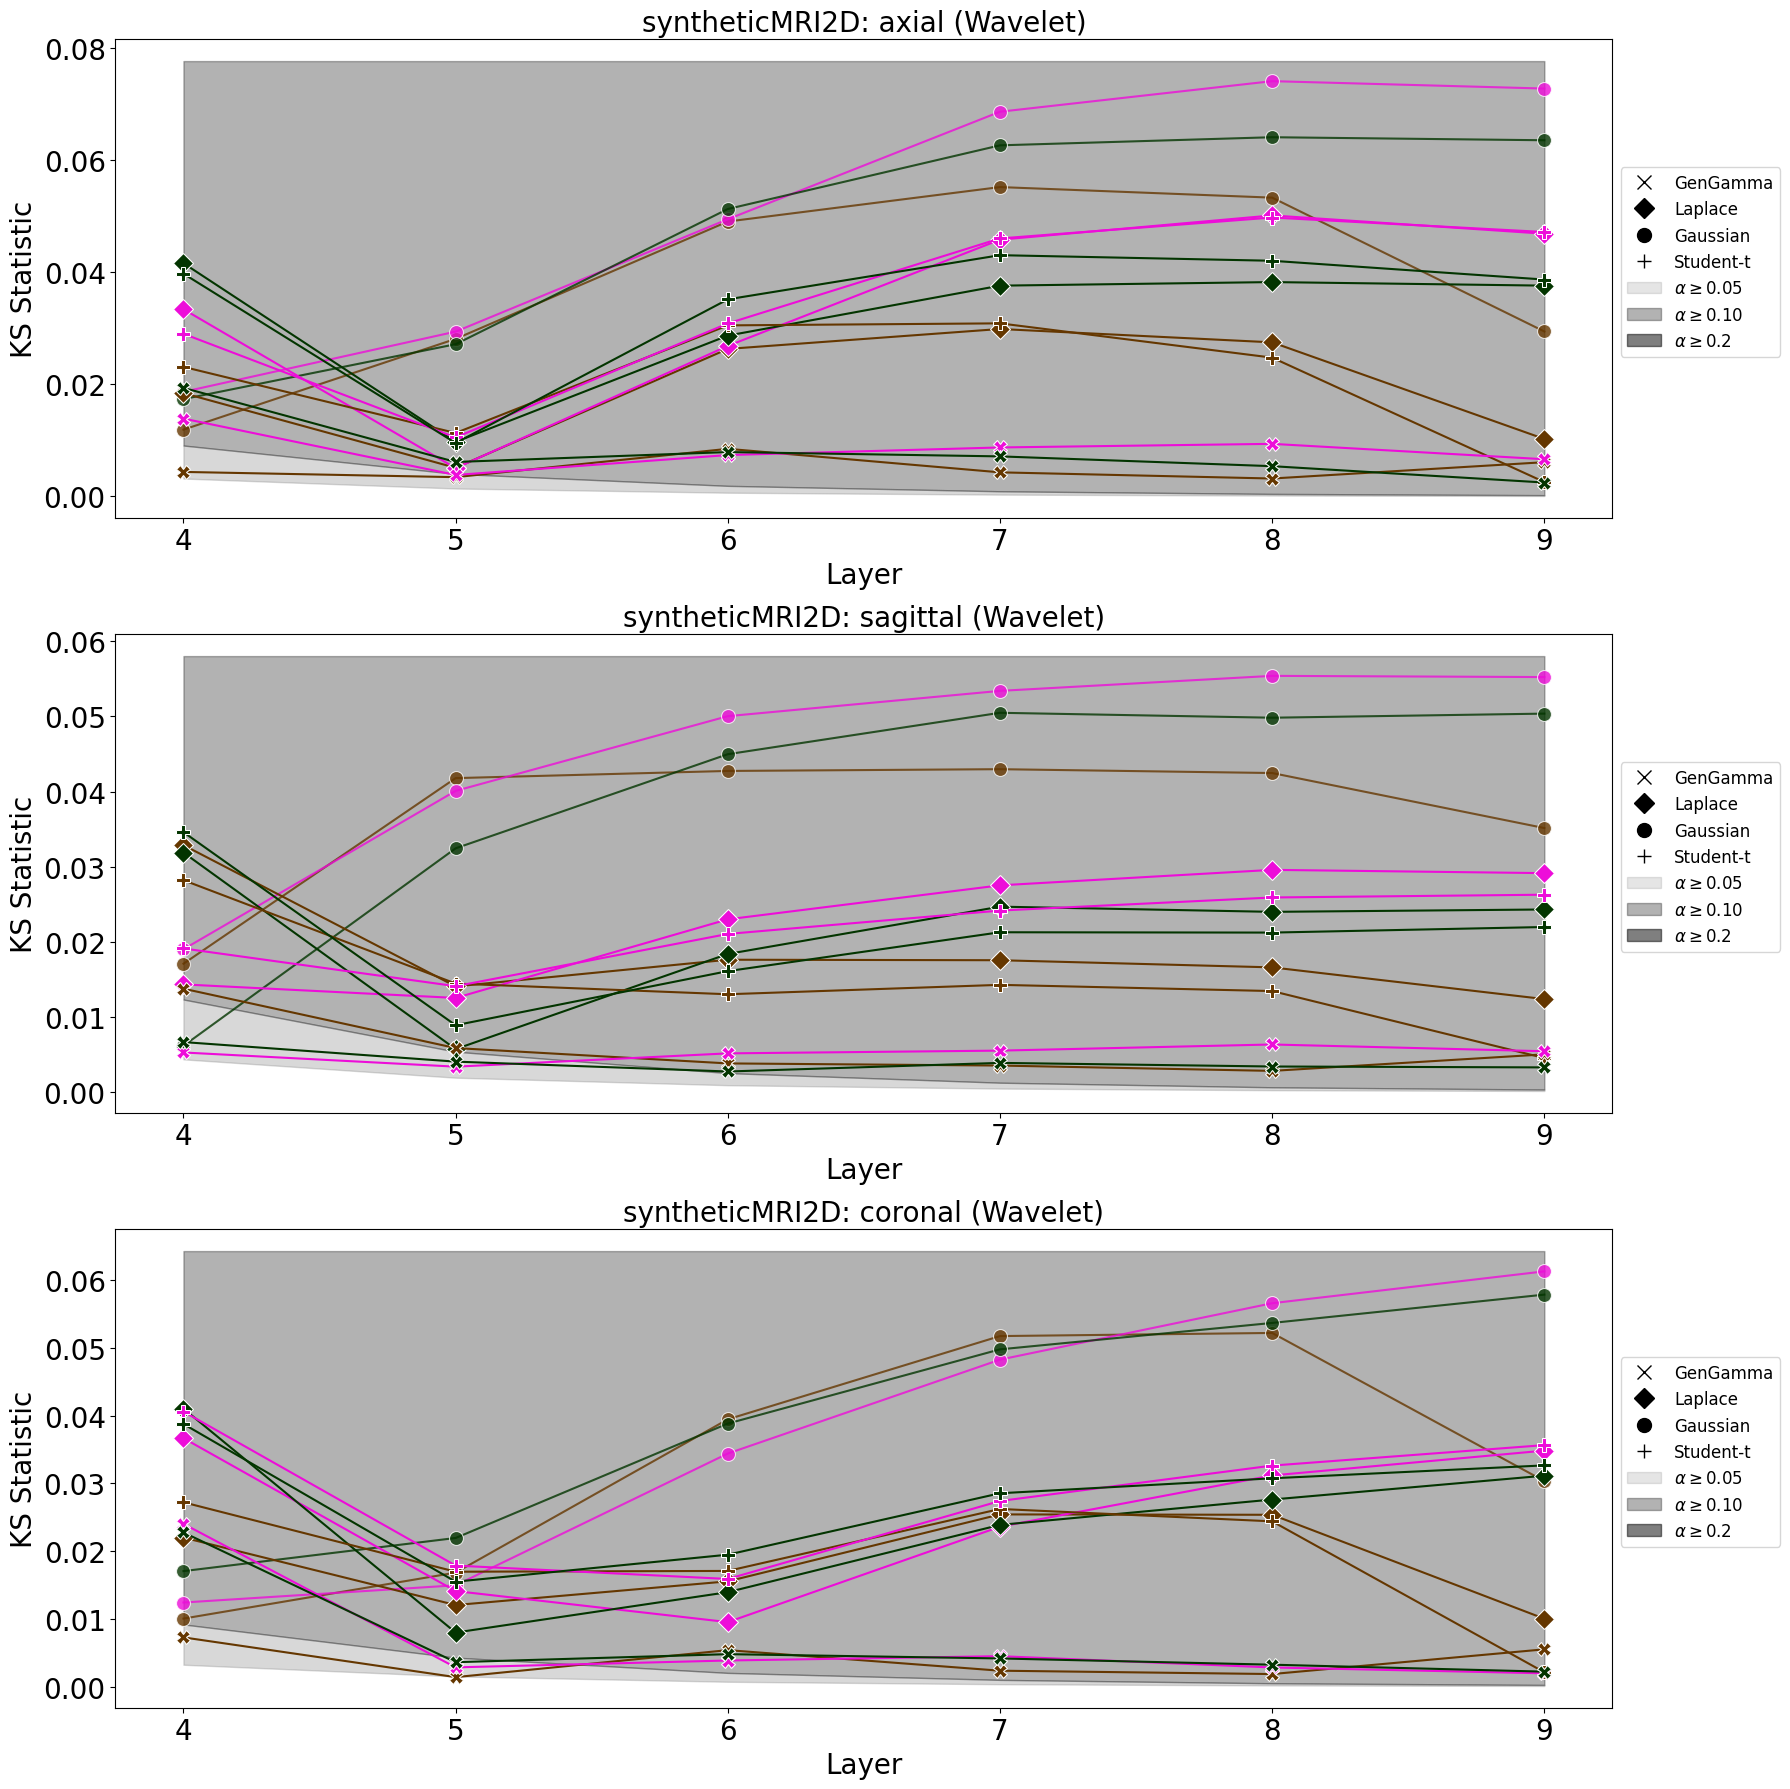

In [ ]:
hue = 'channel'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue', 'horizontal': 'xkcd:fuchsia', 'vertical': 'xkcd:dark green', 'diagonal': 'xkcd:brown'}
marker_size = 10  # Define marker size

datasets_to_include = ['syntheticMRI2D']  # List of datasets to include
dataset_name = datasets_to_include[0]
num_datasets = len(datasets_to_include)
subsets_to_include = ['axial', 'sagittal', 'coronal']  # List of subsets to include
num_subsets = len(subsets_to_include)
fig, axes = plt.subplots(num_subsets, 1, figsize=(18, 6 * num_subsets))

if num_subsets == 1:
    axes = [axes]

for j, subset_name in enumerate(subsets_to_include):
    hue = 'orientation'
    transform = 'wavelet'
    GROUP_NAME = 'Layer'
    dataset_filter = (main_df['dataset'] == dataset_name)
    subset_filter = (main_df['subset'] == subset_name)
    transform_filter = (main_df['transform'] == transform) & (main_df['group'] > 3)
    temp = main_df[dataset_filter & subset_filter & transform_filter]

    sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[j], markersize=marker_size)
    sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[j], markersize=marker_size)
    sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[j], markersize=marker_size)
    sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[j], markersize=marker_size)

    x_lim = axes[j].get_xlim()
    y_lim = axes[j].get_ylim()
    cutoff = temp.groupby('group').agg({'kstest_stat_cutoff_0.05': 'first', 'kstest_stat_cutoff_0.10': 'first'}).reset_index()
    axes[j].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.05'], cutoff['kstest_stat_cutoff_0.10'], color='gray', alpha=0.3)
    axes[j].fill_between(cutoff['group'], cutoff['kstest_stat_cutoff_0.10'], max(y_lim[1], max(cutoff['kstest_stat_cutoff_0.10'])), color='black', alpha=0.3)

    axes[j].set_xlabel(GROUP_NAME, fontsize=fontsize)
    axes[j].set_ylabel("KS Statistic", fontsize=fontsize)
    axes[j].legend(points, labels, fontsize=12, bbox_to_anchor=(1, 0.75))
    axes[j].set_title(f"{dataset_name}: {subset_name} (Wavelet)", fontsize=fontsize)
    axes[j].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()


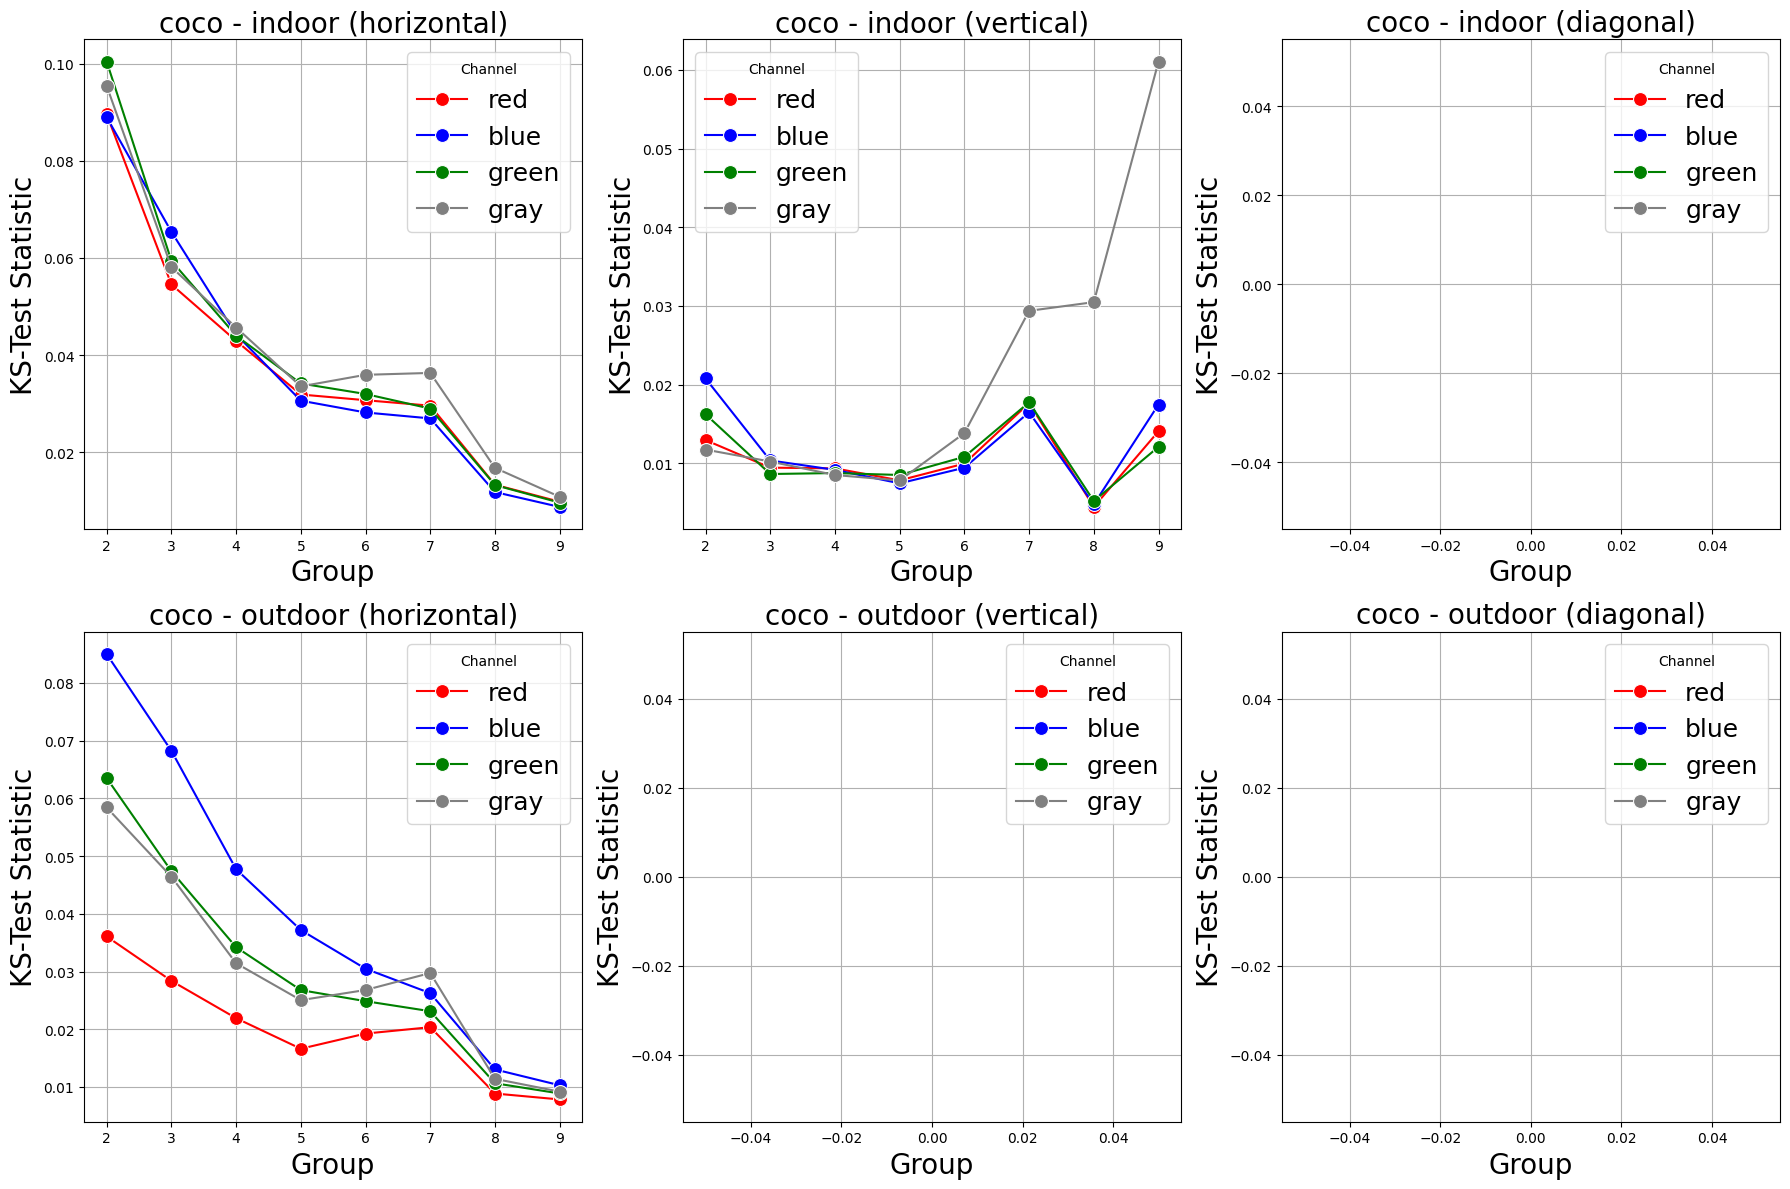

In [ ]:
# Define parameters
dataset_name = 'coco'
subsets_to_include = ['indoor', 'outdoor']
orientations = ['horizontal', 'vertical', 'diagonal']
channels = ['red', 'blue', 'green', 'gray']
fixed_palette = {'horizontal': 'xkcd:light red', 'vertical': 'xkcd:blue', 'diagonal': 'xkcd:green'}
marker_size = 10

# Number of subsets and orientations
num_subsets = len(subsets_to_include)
num_orientations = len(orientations)

# Create figure
fig, axes = plt.subplots(num_subsets, num_orientations, figsize=(6 * num_orientations, 6 * num_subsets))

# Ensure axes is always a 2D array for consistency
if num_subsets == 1:
    axes = [axes]
if num_orientations == 1:
    axes = [[ax] for ax in axes]

# Loop through subsets and orientations
for i, subset_name in enumerate(subsets_to_include):
    for j, orientation in enumerate(orientations):
        # Filter data for the current subset and orientation
        subset_filter = (main_df['dataset'] == dataset_name) & (main_df['subset'] == subset_name) & (main_df['orientation'] == orientation)
        temp = main_df[subset_filter]

        # Plot data for each channel
        for channel in channels:
            channel_filter = temp['channel'] == channel
            sns.lineplot(
                data=temp[channel_filter],
                x='group',
                y='kstest_stat_best',
                label=channel,
                ax=axes[i][j],
                marker='o',
                markersize=marker_size
            )

        # Customize plot
        axes[i][j].set_title(f"{dataset_name} - {subset_name} ({orientation})", fontsize=fontsize)
        axes[i][j].set_xlabel("Group", fontsize=fontsize)
        axes[i][j].set_ylabel("KS-Test Statistic", fontsize=fontsize)
        axes[i][j].legend(title="Channel", fontsize=fontsize - 2).set_visible("False")
        axes[i][j].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## pastis

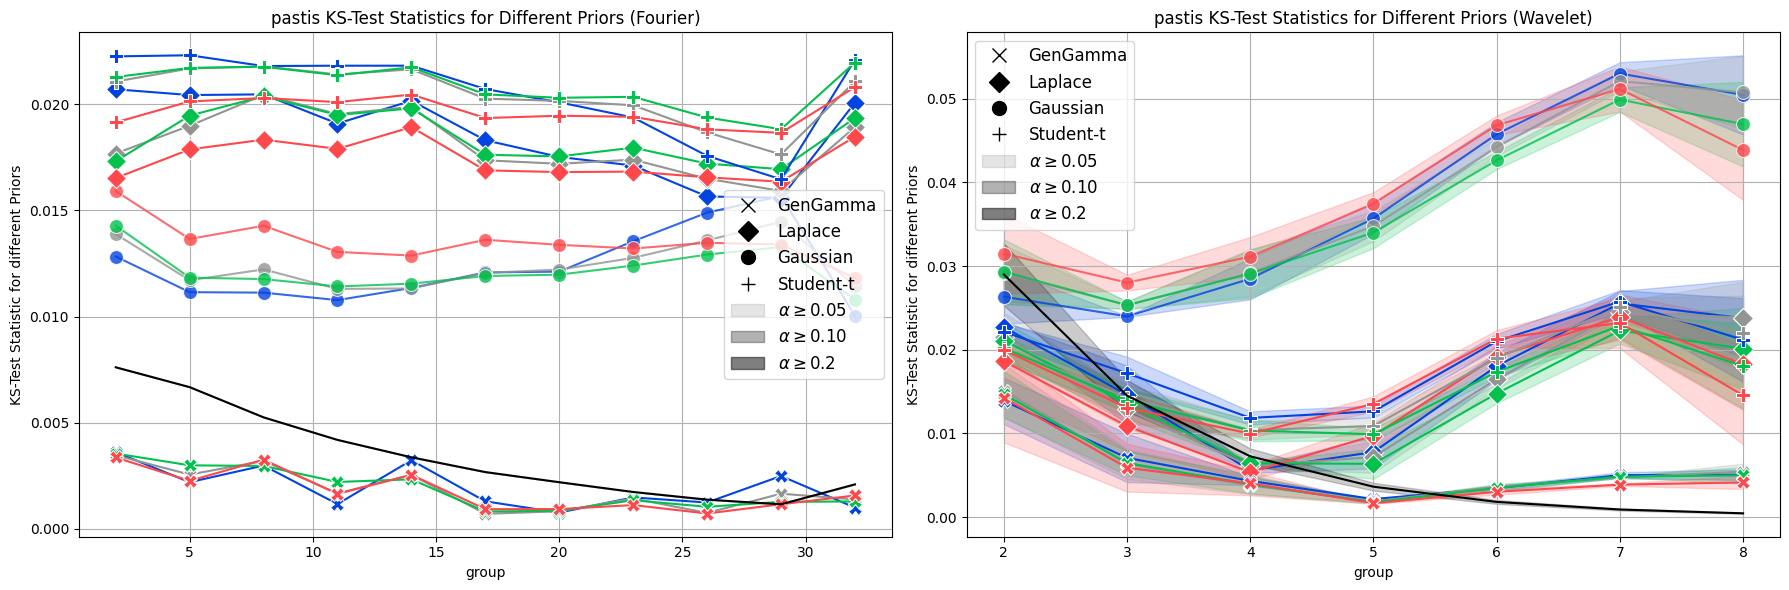

In [ ]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray', 'green': 'xkcd:shamrock green', 'red': 'xkcd:light red', 'blue': 'xkcd:blue'}
marker_size = 10  # Define marker size

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Fourier plot
sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize=marker_size)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize=marker_size)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize=marker_size)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize=marker_size)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0], markersize=marker_size)
axes[0].set_ylabel("KS-Test Statistic for different Priors")
axes[0].legend(points, labels, fontsize=12)
axes[0].grid(True)
axes[0].set_title(f"{dataset_name} KS-Test Statistics for Different Priors (Fourier)")

# Wavelet plot
transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize=marker_size)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize=marker_size)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize=marker_size)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize=marker_size)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1], markersize=marker_size)
axes[1].set_ylabel("KS-Test Statistic for different Priors")
axes[1].legend(points, labels, fontsize=12)
axes[1].grid(True)
axes[1].set_title(f"{dataset_name} KS-Test Statistics for Different Priors (Wavelet)")

plt.tight_layout()
plt.show()


ValueError: Could not interpret value `frequency` for `hue`. An entry with this name does not appear in `data`.

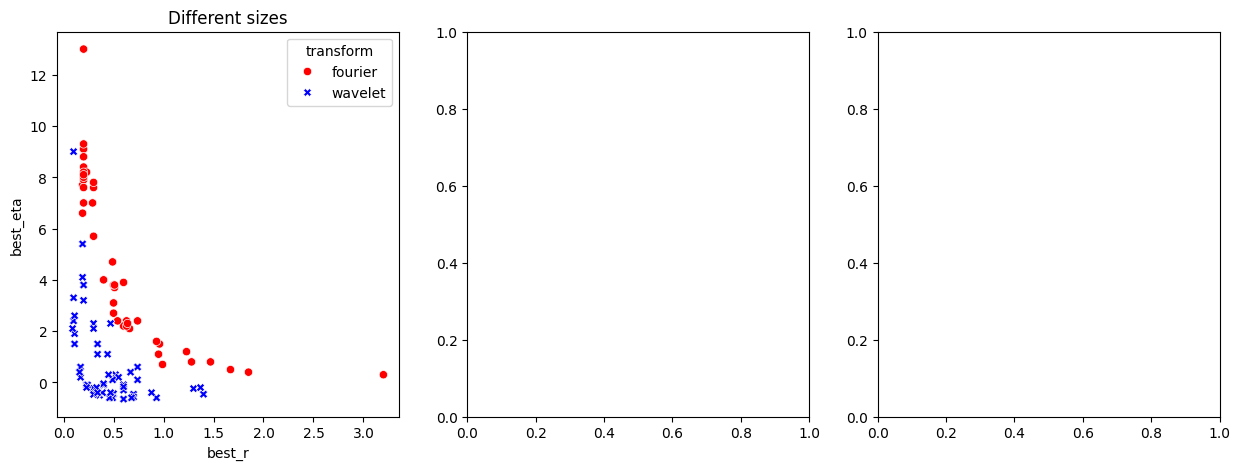

In [ ]:
temp = main_df[dataset_filter]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', style = 'transform', ax=axes[0])
axes[0].set_title('Different sizes')
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='frequency', ax=axes[1])
#sns.scatterplot(data=temp[temp['transform'] == 'wavelet'], x='best_r', y='best_eta', hue='frequency', ax=axes[1])
axes[1].set_title('Different groups')
sns.scatterplot(data=temp, x='frequency', y='param_gaussian', hue='frequency',style='transform', ax=axes[2], marker = '.')
sns.scatterplot(data=temp, x='frequency', y='param_laplace', hue='frequency',style='transform', ax=axes[2], marker = 'D')
sns.scatterplot(data=temp, x='frequency', y='param_t', hue='group',style='transform', ax=axes[2], marker = 'P')
axes[2].set_title('Different groups')
axes[2].set_ylabel('Variance')
axes[2].legend(points[1:], labels[1:])

plt.tight_layout()
plt.show()


In [ ]:
temp = main_df[dataset_filter]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', style = 'transform', ax=axes[0])
axes[0].set_title('Different sizes')
sns.scatterplot(data=temp[temp['transform'] == 'fourier'], x='best_r', y='best_eta', hue='group', palette = 'viridis', ax=axes[1])
sns.scatterplot(data=temp[temp['transform'] == 'wavelet'], x='best_r', y='best_eta', hue='group', ax=axes[1])
axes[1].set_title('Different groups')
sns.scatterplot(data=temp, x='group', y='param_gaussian', hue='group',style='transform', ax=axes[2], marker = '.')
sns.scatterplot(data=temp, x='group', y='param_laplace', hue='group',style='transform', ax=axes[2], marker = 'D')
sns.scatterplot(data=temp, x='group', y='param_t', hue='group',style='transform', ax=axes[2], marker = 'P')
axes[2].set_title('Different groups')
axes[2].legend(points[1:], labels[1:])

plt.tight_layout()
plt.show()


In [ ]:
temp = main_df#[dataset_filter]
log_scale = True
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=temp, x='prior_var', y='prior_kurt', hue='transform', style = 'transform', ax=axes[0])
axes[0].set_title('Different transforms')
if log_scale:
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')

sns.scatterplot(data=temp[temp['transform'] == 'fourier'], x='prior_var', y='prior_kurt', hue='group', palette = 'viridis', ax=axes[1])
sns.scatterplot(data=temp[temp['transform'] == 'wavelet'], x='prior_var', y='prior_kurt', hue='group', ax=axes[1])
axes[1].set_title('Different g')
if log_scale:
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')

sns.scatterplot(data=temp, x='prior_var', y='prior_kurt', hue='dataset', palette = 'viridis', ax=axes[2])
# sns.scatterplot(data=temp[temp['transform'] == 'wavelet'], x='prior_var', y='prior_kurt', hue='dataset', ax=axes[2])

# sns.scatterplot(data=temp, x='param_gaussian', y='gaussian_kurt', hue='group',style='transform', ax=axes[2], marker = '.')
# sns.scatterplot(data=temp, x='param_laplace', y='laplace_kurt', hue='group',style='transform', ax=axes[2], marker = 'D')
#sns.scatterplot(data=temp, x='group', y='param_t', hue='group',style='transform', ax=axes[2], marker = 'P')
axes[2].set_title('Different groups')
#axes[2].set_xlabel('Variance')
#axes[2].legend(points, labels)
if log_scale:
    axes[2].set_xscale('log')
    axes[2].set_yscale('log')

plt.tight_layout()
plt.show()


In [ ]:
temp = main_df[dataset_filter]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', style = 'transform', ax=axes[0])
axes[0].set_title('Different sizes')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='group',style='transform', ax=axes[1])
axes[1].set_title('Different groups')
axes[1].set_xscale('log')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


## agriVision

### Comparing priors (fourier and wavelet)

In [ ]:
hue = 'channel'
dataset_name = 'agriVision'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0])
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0])
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0])
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0])
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_ylabel("KS-Test Statistic for different Priors")
axes[0].legend(points, labels)
axes[0].grid(True)
axes[0].set_title(f"{dataset_name} KS-Test Statistics for Different Priors (Fourier)")

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1])
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1])
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1])
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1])
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_ylabel("KS-Test Statistic for different Priors")
axes[1].legend(points, labels)
axes[1].grid(True)
axes[1].set_title(f"{dataset_name} KS-Test Statistics for Different Priors (Wavelet)")

plt.tight_layout()
plt.show()


### Comparing across batch0 and batch1

In [ ]:
hue='size'
dataset_name = 'agriVision'
transform = 'fourier'

dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)

temp = main_df[dataset_filter & transform_filter]
fixed_palette = None
# fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}
sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker = 'o', alpha=0.8)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker = 'D')
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker = 'P')
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker = 'X')
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', c = 'black')
plt.ylabel("KS-Test Statistic for different Priors")
plt.legend(points, labels)
plt.grid(True)
plt.title(f"{dataset_name} KS-Test Statistics for Different Priors (by {hue} and prior)")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue='channel', style='size', ax=axes[0])
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', c = 'black')
axes[0].set_title('Not grouped by size')
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue='channel', ax=axes[1])
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', c = 'black')
axes[1].set_title('Grouped by size')

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='channel', style='size', ax=axes[0])
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='size', ax=axes[0])
axes[0].set_title('Different sizes')
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='group', style='size', ax=axes[1])
axes[1].set_title('Different groups')

plt.tight_layout()
plt.show()


## spaceNet


In [ ]:
hue = 'channel'
dataset_name = 'spaceNet'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0])
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0])
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0])
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0])
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_ylabel("KS-Test Statistic for different Priors")
axes[0].legend(points, labels)
axes[0].grid(True)
axes[0].set_title(f"{dataset_name} KS-Test Statistics for Different Priors (Fourier)")

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1])
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1])
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1])
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1])
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_ylabel("KS-Test Statistic for different Priors")
axes[1].legend(points, labels)
axes[1].grid(True)
axes[1].set_title(f"{dataset_name} KS-Test Statistics for Different Priors (Wavelet)")

plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
#sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='channel', style='size', ax=axes[0])
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='channel', ax=axes[0])
axes[0].set_title('Different sizes')
sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='group', style='size', ax=axes[1])
axes[1].set_title('Different groups')

plt.tight_layout()
plt.show()


In [ ]:
y_cols = ['initial_eta', 'kstest_stat_initial', 'kstest_stat_cutoff_0.05', 'kstest_stat_eta0',
'best_r_eta0', 'best_r', 'best_eta', 'kstest_stat_best', 'iter1_r',
'iter1_eta', 'kstest_stat_iter1', 'n_pval_0.05', 'param_gaussian',
'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma']

In [ ]:
# Create figure container that will be updated
fig_widget = go.FigureWidget()

# Create the widgets
x_dropdown = widgets.Dropdown(
    options=['initial_r', 'best_r', 'group'],
    value='best_r',
    description='X-axis:'
)

y_dropdown = widgets.Dropdown(
    options=y_cols,
    value='best_eta',
    description='Y-axis:'
)

color_dropdown = widgets.Dropdown(
    options=['None'] + ['dataset','transform', 'size', 'channel'],
    value='channel',
    description='Color:'
)

marker_dropdown = widgets.Dropdown(
    options=['None'] + ['dataset','transform', 'size', 'channel'],
    value='transform',
    description='Marker:'
)

# Create axis limit controls
x_limit = widgets.FloatText(
    value=np.ceil(main_df[x_dropdown.value].max()),
    description='X max:',
    style={'description_width': 'initial'}
)

y_limit = widgets.FloatText(
    value=np.ceil(main_df[y_dropdown.value].max()),
    description='Y max:',
    style={'description_width': 'initial'}
)

# Create filtering controls
filter_column = widgets.Dropdown(
    options=['None'] + ['dataset','transform', 'size', 'channel'],
    value='None',
    description='Filter column:',
    style={'description_width': 'initial'}
)

# Function to update filter value options based on selected column
def update_filter_options(*args):
    if filter_column.value == 'None':
        filter_value.options = ['None']
    else:
        unique_values = main_df[filter_column.value].unique()
        filter_value.options = ['None'] + list(map(str, unique_values))

filter_value = widgets.Dropdown(
    options=['None'],
    value='None',
    description='Filter value:',
    style={'description_width': 'initial'}
)

# Link filter column selection to value options update
filter_column.observe(update_filter_options, 'value')

# Function to create and update the plot
def update_plot(*args):
    # Get current values
    x = x_dropdown.value
    y = y_dropdown.value
    color = color_dropdown.value
    marker = marker_dropdown.value
    x_max = x_limit.value
    y_max = y_limit.value
    filter_col = filter_column.value
    filter_val = filter_value.value

    # Apply filtering
    if filter_col != 'None' and filter_val != 'None':
        col_type = main_df[filter_col].dtype
        if col_type == np.float64 or col_type == np.int64:
            filtered_df = main_df[main_df[filter_col] == float(filter_val)]
        else:
            filtered_df = main_df[main_df[filter_col] == filter_val]
    else:
        filtered_df = main_df.copy()
    
    # Create new figure data
    color_val = None if color == 'None' else color
    symbol_val = None if marker == 'None' else marker
    
    # Create temporary figure to get the correct trace formatting
    temp_fig = px.scatter(filtered_df, 
                         x=x,
                         y=y,
                         color=color_val,
                         symbol=symbol_val)
    
    # Clear existing traces
    fig_widget.data = []
    
    # Add new traces
    for trace in temp_fig.data:
        fig_widget.add_trace(trace)
    
    # Update layout
    fig_widget.update_layout(
        title=f'{y} vs {x}' + (f' (Filtered by {filter_col}={filter_val})' if filter_col != 'None' and filter_val != 'None' else ''),
        title_x=0.5,
        xaxis=dict(title=x, range=[0, x_max]),
        yaxis=dict(title=y, range=[0, y_max]),
        height=600,
        width=800,
        margin=dict(l=20, r=20, t=40, b=20)
    )

# Function to update axis limit defaults when axis selection changes
def update_x_limit(*args):
    x_limit.value = float(main_df[x_dropdown.value].max())

def update_y_limit(*args):
    y_limit.value = float(main_df[y_dropdown.value].max())

# Set up all observers
x_dropdown.observe(update_plot, 'value')
y_dropdown.observe(update_plot, 'value')
color_dropdown.observe(update_plot, 'value')
marker_dropdown.observe(update_plot, 'value')
x_limit.observe(update_plot, 'value')
y_limit.observe(update_plot, 'value')
filter_column.observe(update_plot, 'value')
filter_value.observe(update_plot, 'value')
x_dropdown.observe(update_x_limit, 'value')
y_dropdown.observe(update_y_limit, 'value')

# Organize controls in a more structured layout
axis_controls = widgets.VBox([
    widgets.HBox([x_dropdown, x_limit]),
    widgets.HBox([y_dropdown, y_limit])
])

style_controls = widgets.VBox([
    color_dropdown,
    marker_dropdown
])

filter_controls = widgets.VBox([
    filter_column,
    filter_value
])

# Create tabs for different control groups
tab = widgets.Tab()
tab.children = [axis_controls, style_controls, filter_controls]
tab.set_title(0, 'Axes')
tab.set_title(1, 'Style')
tab.set_title(2, 'Filter')

# Initialize the plot
update_plot()

# Display everything
display(tab, fig_widget)